# SDSS Image Classification - Preprocessing


## Data

This analysis will be making use of image "chips," fragments of images containing only the relevant object of interest. Due to the variable size of these objects (e.g. objects closer to the Earth appear bigger), each image is clipped using a 2-dimensional Gaussian, clipped at $3 \sigma$. This will *usually* prevent other objects from appearing in the image chip, however some objects are so closely spaced together (or sparsely distrubted) that there may be evidence of other objects in some of the image chips.

In [1]:
from pathlib import Path
import pickle


from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import pandas as pd
import numpy as np
np.random.seed(42)
tf.random.set_seed(42)

# plots
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# stats stuff
from astropy.stats import sigma_clip




In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# data_dir = Path("/content/drive/MyDrive/MIDS/207/SDSS-Classification/data")
data_dir = Path("./data/64x64")


In [4]:
# Figure out how many images and objects we want to use

# load google drive
chips_dir = Path("./chips2")
chips_dir.exists()
chips_dir_contents = chips_dir.glob("**/*.jpeg")


# load image chips
chips_dir_contents = [content for content in chips_dir_contents]

generated_idxs = np.array(list(set([int(content.name.split('-')[0]) for content in chips_dir_contents])))
print(f"There are {len(generated_idxs)} objects with images.")
print(f"With {len(chips_dir_contents)} total images")

# lets limit to 50,000 objects
# generated_idxs = generated_idxs[:74000]
print(len(generated_idxs))

There are 94569 objects with images.
With 347959 total images
94569


In [5]:
target_width = target_height = 64
imgs = np.ndarray(shape=(len(chips_dir_contents), target_width, target_height))
labels = []

for idx,content in enumerate(chips_dir_contents):
    label = content.stem.split("-")[-1]
    labels.append(label)
    object_img = load_img(
        content,
        color_mode="grayscale",
        target_size=(target_width, target_height),
    )
    img_arr = img_to_array(object_img) / 255
    imgs[idx] = img_arr.reshape((target_width, target_height))


In [6]:

# # Loads the banded data

# bands = ['u', 'g', 'r', 'i', 'z']

# if Path(data_dir / "imgs.pkl").exists():
#     print(f"Found pickled images, loading from pickle...")
#     with open(data_dir / "imgs.pkl", "rb") as f:
#         imgs = pickle.load(f)

# else:

#     # organize the chips into an ndim array
#     # target_size = (64, 64)
#     target_width = 64
#     target_height = 64
#     target_size = (target_width, target_height)
#     imgs = np.ndarray((len(generated_idxs)+1, target_width, target_height, 5))

#     for gen_idx in generated_idxs:
#         print(f"Loading object {gen_idx} images... of {len(generated_idxs)} with max = {max(generated_idxs)}", end="\r")
#         object_imgs = np.ndarray((target_width, target_height, 5))
#         try:
#             for idx, band in enumerate(bands):
#                 img_path = f"{gen_idx}-{band}.jpeg"
#                 object_img = load_img(
#                     chips_dir / img_path,
#                     color_mode="grayscale",
#                     target_size=target_size
#                 )
#                 img_arr = img_to_array(object_img)/255 # rescale to floats (0,1)
#                 object_imgs[:,:,idx] = img_arr.reshape(target_width, target_height)
#         except Exception as e:
#             print(f"Error loading image {img_path} for object {gen_idx}")
#             continue
        
#         imgs[gen_idx] = object_imgs

#     print(len(imgs))





In [7]:

def calc_noise(img_data):
  clipped = sigma_clip(img_data, sigma=3 )
  sigma = np.std(clipped)
  return (sigma)





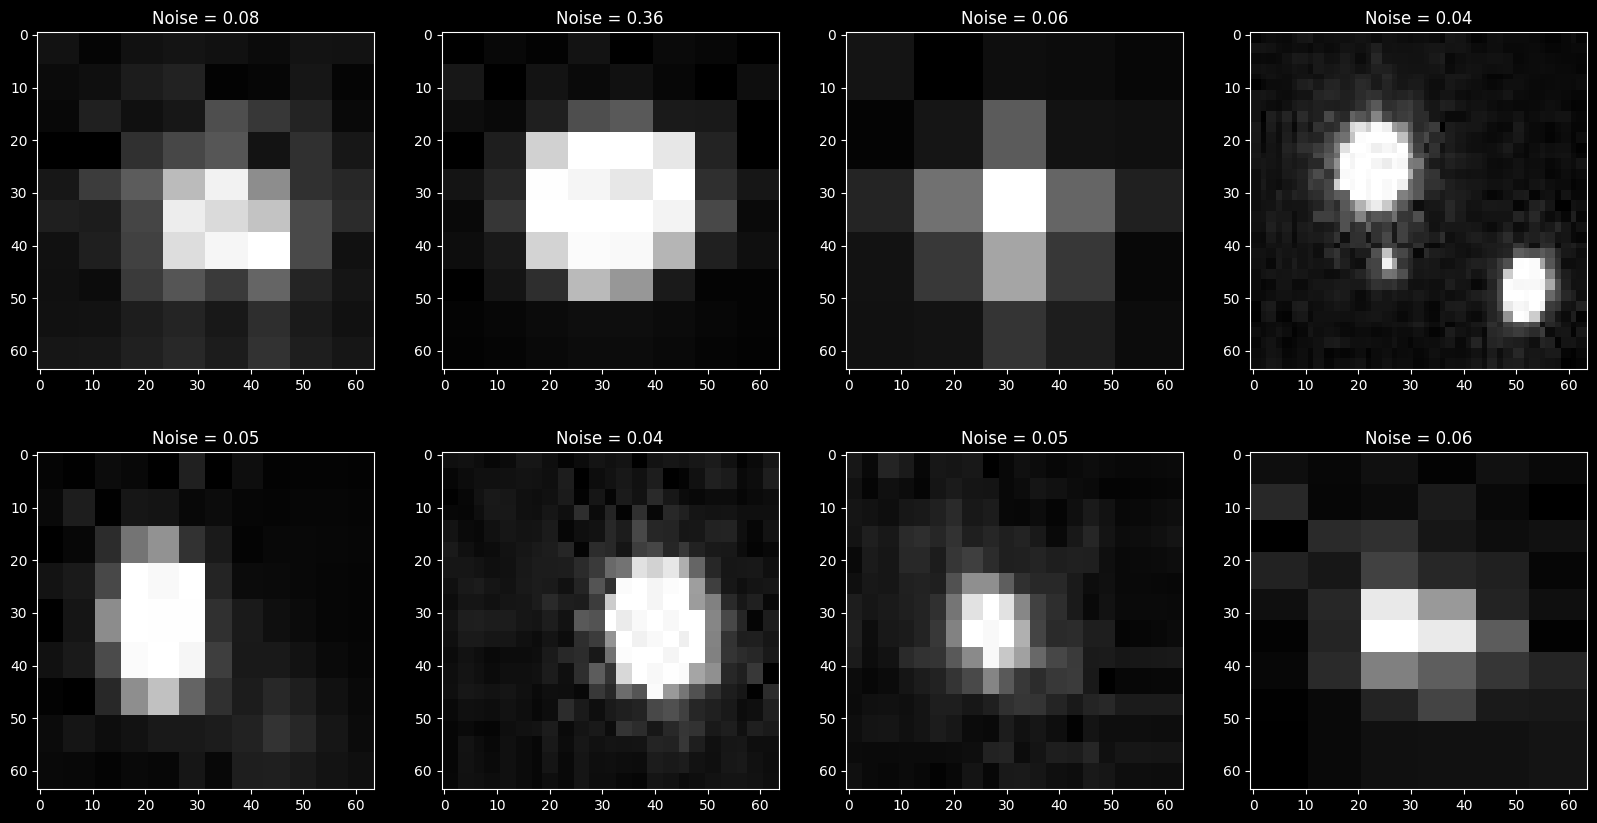

In [8]:
import matplotlib.pyplot as plt
nrows = 2
ncols = 4

rand_idxs = np.random.randint(0, len(imgs), 8)
rand_band = np.random.randint(0, 5, 8)
plot_imgs = imgs[rand_idxs]
snr_titles= [f"Noise = {calc_noise(img):.2f}" for img in plot_imgs]

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,10))

for i in range(nrows):
  for j in range(ncols):
    
    plot_idx = i*ncols + j
    band_idx = rand_band[i*ncols + j]
    ax[i, j].imshow(plot_imgs[plot_idx,:,:], cmap='gray')
    ax[i,j].set_title(f"{snr_titles[plot_idx]}")
    


In [9]:

with open(data_dir / "imgs.pkl", "wb") as f:
    pickle.dump(imgs, f)





## Data Processing

Due to the asymetrical nature of the data (reference the label distributions in the EDA.ipynb), we will be randomly throwing out some of our images in order to train our models on a more evenly distributed data set.


In [10]:
X = imgs
y = np.array(labels)

In [11]:
np.unique(y, return_counts=True)


(array(['GALAXY', 'QSO', 'STAR'], dtype='<U6'),
 array([193211,  64768,  89980], dtype=int64))

In [12]:
le = LabelEncoder()
le.fit(y)
y_transformed = le.transform(y)
ref_list = ["GALAXY", "QSO", "STAR"]
print(ref_list)
trans_ref_list = le.transform(ref_list)
print(trans_ref_list)


['GALAXY', 'QSO', 'STAR']
[0 1 2]


In [13]:
np.unique(y_transformed, return_counts=True)


(array([0, 1, 2]), array([193211,  64768,  89980], dtype=int64))

In [14]:
np.where(y_transformed == 0)[0]


array([     0,      1,      2, ..., 347956, 347957, 347958], dtype=int64)

In [15]:
# balance the data using the dataframes


GALAXY = le.transform(["GALAXY"])[0]
QSO = le.transform(["QSO"])[0]
STAR = le.transform(["STAR"])[0]
# randomly throw out some samples so we have an balanced distribtuion.
n_samples = len(y_transformed[y_transformed == QSO]) # QSO has the smallest number of samples.

qso_idxs = np.where(y_transformed == QSO)[0]


galaxy_idxs = np.random.choice(
    np.where(y_transformed == GALAXY)[0],
    n_samples, 
    replace=False)

star_idxs = np.random.choice(
    np.where(y_transformed == STAR)[0],
    n_samples, 
    replace=False)


balanced_idxs = np.concatenate([qso_idxs, galaxy_idxs, star_idxs])

balanced_y = y_transformed[balanced_idxs]
balanced_X  = X[balanced_idxs]

print(np.unique(balanced_y, return_counts=True))

(array([0, 1, 2]), array([64768, 64768, 64768], dtype=int64))


In [16]:

# lets do some image transformations so we can have more robust training data
CONTRAST_FACTOR = 0.3
BRIGHTNESS_FACTOR = 0.3
FLIP = True 


def preprocess_images(images, labels, split=[0.6, 0.2, 0.2], brightness_factor=BRIGHTNESS_FACTOR, contrast_factor=CONTRAST_FACTOR, flip=FLIP):
    print("Preprocessing images...")
    shuffle = np.random.permutation(len(images))
    images, y = images[shuffle], labels[shuffle]

    splits = np.multiply(len(images),split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y, [splits[0], splits[0]+splits[1]])

    print("Starting with {} training samples, {} validation samples, and {} test samples".format(len(X_train), len(X_val), len(X_test)))

    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm = tf.image.adjust_brightness(X_train, delta=BRIGHTNESS_FACTOR)
    
    # adjust contrast
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=contrast_factor)

    # random flip
    if flip:
        X_train_augm = tf.image.random_flip_left_right(X_train_augm)
    
    # concatenate original X_train and augmented X_train data
    X_train = tf.concat([X_train, X_train_augm],axis=0)

        # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)

    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    
    print("Finishing with {} training samples, {} validation samples, and {} test samples".format(len(X_train), len(X_val), len(X_test)))
    return X_train, y_train, X_val, y_val, X_test, y_test

    

In [17]:

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_images(balanced_X, balanced_y)

Preprocessing images...
Starting with 116582 training samples, 38860 validation samples, and 38862 test samples
Finishing with 233164 training samples, 38860 validation samples, and 38862 test samples


In [18]:

out_dir = data_dir

with open(out_dir / "X_train.pkl", "wb") as f:
    pickle.dump(X_train, f)

with open(out_dir / "y_train.pkl", "wb") as f:
    pickle.dump(y_train, f)

with open(out_dir / "X_val.pkl", "wb") as f:
    pickle.dump(X_val, f)

with open(out_dir / "y_val.pkl", "wb") as f:
    pickle.dump(y_val, f)

with open(out_dir / "X_test.pkl", "wb") as f:
    pickle.dump(X_test, f)
    
with open(out_dir / "y_test.pkl", "wb") as f:
    pickle.dump(y_test, f)


In [45]:
# use the df when we are working with ordered indexes

# bands = ["u", "g", "r", "i", "z"]



# # load in the labels
# df = pd.read_csv("data/star_classification.csv")

# # we are only using the first 50,000 objects
# df = df.iloc[:len(imgs)]
# df.head()
# obj_dist = (df.groupby("class").count()/len(df))['obj_ID']*100
# obj_dist



In [27]:
# encode labels for df
# le = LabelEncoder()
# le.fit(df["class"])
# df['class'] = le.transform(df["class"])
# ref_list = ["GALAXY", "QSO", "STAR"]
# print(ref_list)
# trans_ref_list = le.transform(ref_list)
# print(trans_ref_list)

['GALAXY', 'QSO', 'STAR']
[0 1 2]


In [28]:
# # balance the data using the dataframes


# GALAXY = le.transform(["GALAXY"])[0]
# QSO = le.transform(["QSO"])[0]
# STAR = le.transform(["STAR"])[0]
# # randomly throw out some samples so we have an balanced distribtuion.
# n_samples = len(df[df['class'] == QSO]) # QSO has the smallest number of samples.

# qso_idxs = df[df['class'] == QSO].index

# galaxy_idxs = np.random.choice(
#     df[df['class'] == GALAXY].index, 
#     n_samples, 
#     replace=False)

# star_idxs = np.random.choice(
#     df[df['class'] == STAR].index, 
#     n_samples, 
#     replace=False)


# balanced_idxs = np.concatenate([qso_idxs, galaxy_idxs, star_idxs])

# balanced_df = df.iloc[balanced_idxs]


# balanced_obj_dist = (balanced_df.groupby("class").count()/len(balanced_df))['obj_ID']*100




# # now balance the actual images
# balanced_imgs = imgs[balanced_idxs, :, :, :]
# print(balanced_obj_dist)
# print(balanced_imgs.shape)


IndexError: index 681 is out of bounds for axis 0 with size 679

In [8]:
# # lets do some image transformations so we can have more robust training data
# CONTRAST_FACTOR = 0.3
# BRIGHTNESS_FACTOR = 0.3
# FLIP = True 


# def preprocess_images(images, df, split=[0.6, 0.2, 0.2], brightness_factor=BRIGHTNESS_FACTOR, contrast_factor=CONTRAST_FACTOR, flip=FLIP):
#     print("Preprocessing images...")
#     shuffle = np.random.permutation(len(images))
#     images, y = images[shuffle], df['class'].values[shuffle]

#     splits = np.multiply(len(images),split).astype(int)
#     X_train, X_val, X_test = np.split(images, [splits[0], splits[0]+splits[1]])
#     y_train, y_val, y_test = np.split(y, [splits[0], splits[0]+splits[1]])

#     print("Starting with {} training samples, {} validation samples, and {} test samples".format(len(X_train), len(X_val), len(X_test)))

#     ### image augmentation on training data ###
#     ###########################################
#     # adjust brightness
#     X_train_augm = tf.image.adjust_brightness(X_train, delta=BRIGHTNESS_FACTOR)
    
#     # adjust contrast
#     X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=contrast_factor)

#     # random flip
#     if flip:
#         X_train_augm = tf.image.random_flip_left_right(X_train_augm)
    
#     # concatenate original X_train and augmented X_train data
#     X_train = tf.concat([X_train, X_train_augm],axis=0)

#         # concatenate y_train (note the label is preserved)
#     y_train_augm = y_train
#     y_train = tf.concat([y_train, y_train_augm],axis=0)

    
#     # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
#     shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
#     X_train = tf.gather(X_train, shuffle)
#     y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    
#     print("Finishing with {} training samples, {} validation samples, and {} test samples".format(len(X_train), len(X_val), len(X_test)))
#     return X_train, y_train, X_val, y_val, X_test, y_test

    

In [9]:
# X_train, y_train, X_val, y_val, X_test, y_test = preprocess_images(balanced_imgs, balanced_df)


Preprocessing images...
Starting with 25288 training samples, 8429 validation samples, and 8430 test samples


ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[25288,64,64,5] and type double on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:Mul]

In [15]:
out_dir = data_dir.parent / "more_data"

with open(out_dir / "X_train.pkl", "wb") as f:
    pickle.dump(X_train, f)

with open(out_dir / "y_train.pkl", "wb") as f:
    pickle.dump(y_train, f)

with open(out_dir / "X_val.pkl", "wb") as f:
    pickle.dump(X_val, f)

with open(out_dir / "y_val.pkl", "wb") as f:
    pickle.dump(y_val, f)

with open(out_dir / "X_test.pkl", "wb") as f:
    pickle.dump(X_test, f)
    
with open(out_dir / "y_test.pkl", "wb") as f:
    pickle.dump(y_test, f)


## Models

I will be taking two approaches to this problem: One using the raw chip data (e.g. no transformations) and another scaling the chip data to have the same dimensions. This in turn will require using differing models, Fully Connected Network (FCN) and a Convolutional Neural Network (CNN).

### Fully Connected Network


In [ ]:
# FCN implementation here

### Convolutional Neural Network

In [ ]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential()

# add first convolution layer to the model
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))


# add second convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2')
)


# add a fully connected layer (need to flatten the output of the previous layers first)
model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1', 
    activation='relu'))

# add dropout layer
model.add(tf.keras.layers.Dropout(
    rate=0.5))

# add the last fully connected layer
# this last layer sets the activation function to "None" in order to output the logits 
# note that passing activation = "sigmoid" will return class memembership probabilities but
# in TensorFlow logits are prefered for numerical stability
# set units=1 to get a single output unit (remember it's a binary classification problem)
model.add(tf.keras.layers.Dense(
    units=3,
    name='fc_2',
    activation=None))






model.build(input_shape=(None, 64, 64, 5))
model.summary()


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-1),
              loss=tf.keras.losses.sparse_categorical_crossentropy, #set from_ligits=True because our last layer does not apply sigmoid
              metrics=['accuracy']) 


In [ ]:
history = model.fit(
    x = X_train,
    y = y_train,
    epochs=10, 
    batch_size=512,
    validation_data=(X_val, y_val)
)


In [ ]:
X_train.shape


In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show(   )